# Agent(s) in Haystack

A Haystack `Agent` is a component that can be used in pipelines like any other component. The `Agent` uses the provided "tools" to fulfill the users request.



The `Agent`-class encapsulates lower-level Haystack components like `ChatGenerator` and `ToolInvoker`. It composes these lower-level components into a looping pipeline that runs until a "handoff"-condition is met.

In [1]:
!pip install anthropic-haystack -q

In [2]:
import os
from getpass import getpass
from typing import List

from github_components.issue_viewer import GithubIssueViewer

# We created a set of tools that can interact with GitHub
from github_components.repo_viewer import GithubRepositoryViewer

# Standard Haystack imports
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import OutputAdapter
from haystack.dataclasses import ChatMessage, Document
from haystack_integrations.components.generators.anthropic.chat.chat_generator import AnthropicChatGenerator

# Experimental imports needed for our Agent
from haystack_experimental.components.agents import Agent
from haystack_experimental.tools.component_tool import ComponentTool
from haystack_experimental.tools.from_function import tool


In [3]:
from agent_prompts import issue_prompt, repo_viewer_prompt, repo_viewer_schema

In [4]:
def message_handler(documents) -> str:
    """
    Handles the tool output before conversion to ChatMessage.
    """
    result_str = ""
    for document in documents:
        if document.meta["type"] in ["file", "dir", "error"]:
            result_str += document.content + "\n"
        else:
            result_str += f"File Content for {document.meta['path']}\n\n"
            result_str += document.content

    if len(result_str) > 150_000:
        result_str = result_str[:150_000] + "...(large file can't be fully displayed)"

    return result_str

In [5]:
repo_viewer_tool = ComponentTool(
    name="view_repository",
    description=repo_viewer_prompt,
    parameters=repo_viewer_schema,
    component=GithubRepositoryViewer(),
    outputs={
        "message": {"source": "documents", "handler": message_handler},
        "documents": {"source": "documents"},
    },
    inputs={} # TODO: this prevents automatic overrides of repo (for the multi-agent use case)
)

In [6]:
@tool
def create_comment(comment: str) -> str:
    """
    Use this to create a Github comment once you finished your exploration.
    """
    return comment

In [7]:
os.environ["ANTHROPIC_API_KEY"] = getpass("Anthropic Key: ")

In [8]:
chat_generator = AnthropicChatGenerator(model="claude-3-5-sonnet-latest", generation_kwargs={"max_tokens": 8000})

In [9]:
agent = Agent(
    chat_generator=chat_generator,
    system_prompt=issue_prompt,
    tools=[repo_viewer_tool, create_comment],
    exit_condition="create_comment",
    state_schema={"documents": {"type": List[Document]}},
)

/Users/mathislucka/Library/Application Support/hatch/env/virtual/haystack-experimental/0WxCzKa9/haystack-experimental/lib/python3.12/site-packages/haystack/components/routers/conditional_router.py:195: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


In [10]:
issue_template = """
Issue from: {{ url }}
{% for document in documents %}
{% if loop.index == 1 %}
**Title: {{ document.meta.title }}**
{% endif %}
<issue-comment>
{{document.content}}
</issue-comment>
{% endfor %}
    """

issue_builder = ChatPromptBuilder(template=[ChatMessage.from_user(issue_template)])

issue_fetcher = GithubIssueViewer()

In [11]:
pp = Pipeline()

pp.add_component("issue_fetcher", issue_fetcher)
pp.add_component("issue_builder", issue_builder)
pp.add_component("agent", agent)

pp.connect("issue_fetcher.documents", "issue_builder.documents")
pp.connect("issue_builder.prompt", "agent.messages")

🚅 Components
  - issue_fetcher: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - agent: Agent
🛤️ Connections
  - issue_fetcher.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> agent.messages (List[ChatMessage])

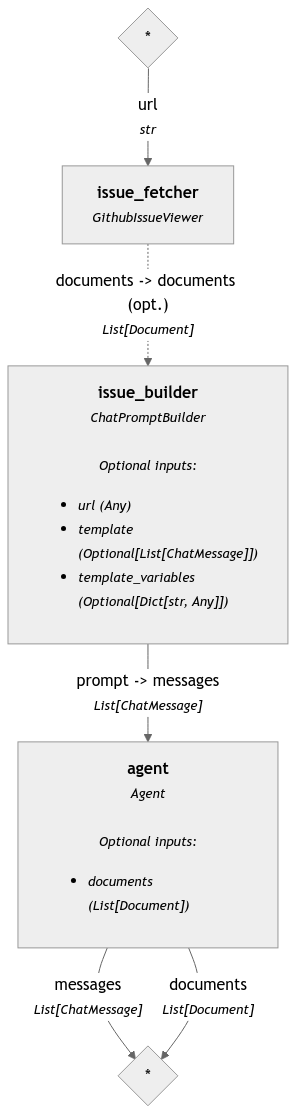

In [12]:
pp.show()

In [13]:
issue_url = "https://github.com/deepset-ai/haystack-core-integrations/issues/1268"

In [14]:
result = pp.run({"url": issue_url})

In [15]:
from IPython.display import Markdown, display

display(Markdown("# Comment from Agent\n\n" + result["agent"]["messages"][-1].tool_call_result.result))

# Comment from Agent

Hi there! Thanks for reporting this issue. I've analyzed the code and can confirm this is indeed a bug in how custom queries handle empty filters.

The problem occurs in the `_prepare_embedding_search_request` method of `OpenSearchDocumentStore` where we unconditionally try to normalize empty filters when using a custom query. Your proposed solution is heading in the right direction - we should only include the `$filters` placeholder in the substitutions if filters actually exist.

Here's the proposed fix for the `_prepare_embedding_search_request` method:

```python
if isinstance(custom_query, dict):
    query_placeholders = {"$query_embedding": query_embedding}
    if filters:
        query_placeholders["$filters"] = normalize_filters(filters)
    body = self._render_custom_query(custom_query, query_placeholders)
```

This change means:
1. We always include the required `$query_embedding` placeholder
2. We only include and normalize `$filters` if filters are actually provided
3. Custom queries without filters will work correctly
4. Custom queries with filters will continue to work as before

This maintains backward compatibility while fixing the issue with empty filters. It's a more robust implementation that properly handles optional filter parameters in custom queries.

Would you mind creating a PR with this change? I'd be happy to review it.

_Let's see what files our Agent looked at_

In [16]:
for document in result["agent"]["documents"]:
    if document.meta["type"] in ["file_content"]:
        display(Markdown(f"[{document.meta['url']}]({document.meta['url']})"))

[https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py](https://github.com/deepset-ai/haystack-core-integrations/blob/main/integrations/opensearch/src/haystack_integrations/document_stores/opensearch/document_store.py)

# From Agent to Multi-Agent

Let's make this agent a little more powerful.
We will pass the issue comments and the generated proposal to a second agent.
We also fork the original repository so that we can make edits.

The `Agent` will then:
* view relevant files
* perform edits commit by commit
* return a PR title and description once it is ready to go

In [17]:
from github_components.file_editor import GithubFileEditor
from github_components.repository_forker import GithubRepoForker

In [18]:
# Either classic token or a fine-grained token that can create repositories and commit code
os.environ["GITHUB_TOKEN"] = getpass("Github Token: ")

In [19]:
repo_forker = GithubRepoForker(create_branch=True, auto_sync=True, wait_for_completion=True)
pp.add_component("repo_forker", repo_forker)

In [20]:
from agent_prompts.file_editor_tool import file_editor_prompt, file_editor_schema
from agent_prompts.pr_system_prompt import system_prompt as pr_prompt

In [21]:
editor_tool = ComponentTool(
    name="file_editor",
    description=file_editor_prompt,
    parameters=file_editor_schema,
    component=GithubFileEditor()
)

@tool(inputs={"title": "pr_title"})
def create_pr(pr_title: str, body: str) -> str:
    """
    Use this to create a Github PR once you are done with your changes.
    """
    return pr_title + "\n\n" + body

In [22]:
pr_chat_generator = AnthropicChatGenerator(model="claude-3-5-sonnet-latest", generation_kwargs={"max_tokens": 8000})

In [23]:
pr_agent = Agent(
    chat_generator=pr_chat_generator,
    system_prompt=pr_prompt,
    tools=[editor_tool, create_pr, repo_viewer_tool],
    exit_condition="create_pr",
    state_schema={"repo": {"type": str}, "branch": {"type": str}, "title": {"type": str}},
)

pp.add_component("pr_agent", pr_agent)
adapter = OutputAdapter(
    template="{{issue_messages + [((agent_messages|last).tool_call_result.result)|user_message]}}",
    custom_filters={"user_message": ChatMessage.from_user},
    output_type=List[ChatMessage], unsafe=True
)
pp.add_component("adapter", adapter)

/Users/mathislucka/Library/Application Support/hatch/env/virtual/haystack-experimental/0WxCzKa9/haystack-experimental/lib/python3.12/site-packages/haystack/components/converters/output_adapter.py:79: UserWarning: Unsafe mode is enabled. This allows execution of arbitrary code in the Jinja template. Use this only if you trust the source of the template.
  warn(msg)


In [24]:
pp.connect("repo_forker.issue_branch", "pr_agent.branch")
pp.connect("repo_forker.repo", "pr_agent.repo")
pp.connect("agent.messages", "adapter.agent_messages")
pp.connect("issue_builder.prompt", "adapter.issue_messages")
pp.connect("adapter.output", "pr_agent.messages")

🚅 Components
  - issue_fetcher: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - agent: Agent
  - repo_forker: GithubRepoForker
  - pr_agent: Agent
  - adapter: OutputAdapter
🛤️ Connections
  - issue_fetcher.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> agent.messages (List[ChatMessage])
  - issue_builder.prompt -> adapter.issue_messages (List[ChatMessage])
  - agent.messages -> adapter.agent_messages (List[ChatMessage])
  - repo_forker.issue_branch -> pr_agent.branch (str)
  - repo_forker.repo -> pr_agent.repo (str)
  - adapter.output -> pr_agent.messages (List[ChatMessage])

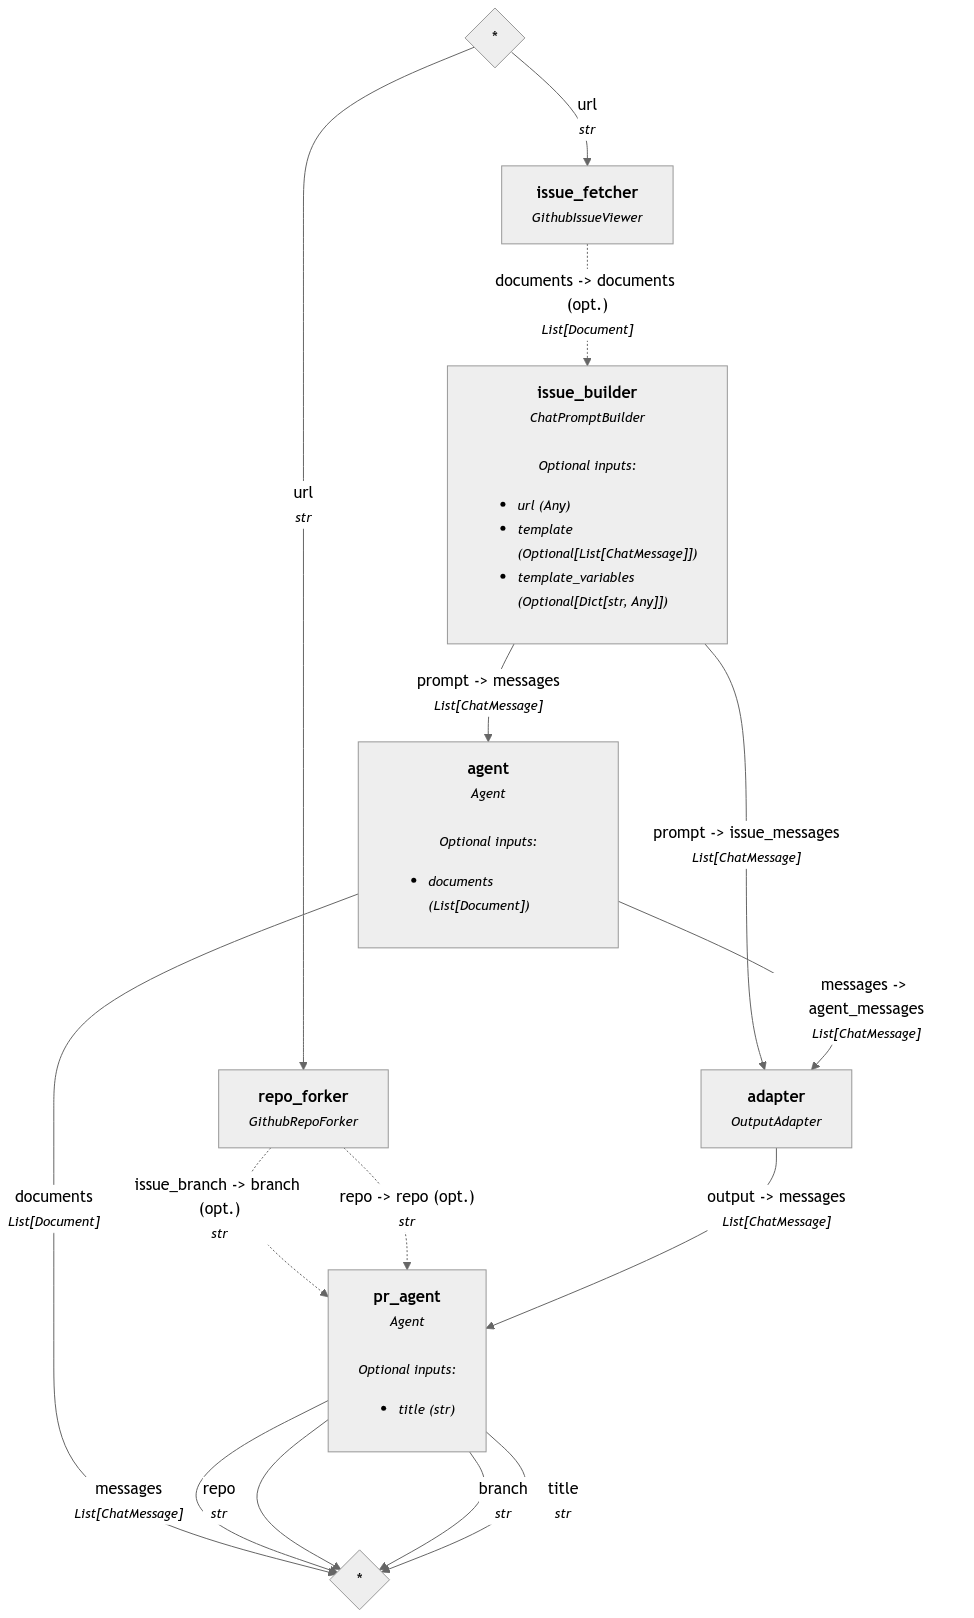

In [25]:
pp.show()

In [28]:
result = pp.run(data={"url": issue_url, "title": "# Agent PR"})

In [29]:
from IPython.display import Markdown, display

display(Markdown("# Comment from Agent\n\n" + result["pr_agent"]["messages"][-1].tool_call_result.result))

# Comment from Agent

# Agent PR

This PR fixes an issue where OpenSearchEmbeddingRetriever's custom_query would fail if no filters were provided.

**Current Behavior**
Currently, when using `custom_query` without filters (either empty dict `{}` or `None`), the OpenSearchEmbeddingRetriever errors out with: 
```
FilterError: 'operator' key missing in {}
```

This happens because the code unconditionally tries to normalize filter values, even when no real filters are provided.

**Changes Made**
Modified `_prepare_embedding_search_request` to only process and include filters in the query placeholder dictionary when filters are actually provided.

```diff
- query_parameters = {
-     "$query_embedding": query_embedding,
-     "$filters": normalize_filters(filters),  # type:ignore
- }
+ query_parameters = {"$query_embedding": query_embedding}
+ if filters:
+     query_parameters["$filters"] = normalize_filters(filters)
```

This makes filter inclusion truly optional when using custom queries, as is defined in the code documentation.

Fixes #1268